# Importações 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sys
import os

# Dados Meteo

In [2]:
sys.path.append(os.path.abspath(".."))
from meteorology.data.meteorology_data import GetMeteorologyData
df = GetMeteorologyData()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29973 entries, 0 to 29972
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          29973 non-null  datetime64[ns]
 1   temp              29973 non-null  float64       
 2   feelslike         29973 non-null  float64       
 3   dew               29973 non-null  float64       
 4   humidity          29973 non-null  float64       
 5   precip            28966 non-null  float64       
 6   precipprob        29973 non-null  float64       
 7   preciptype        804 non-null    object        
 8   windgust          2088 non-null   float64       
 9   windspeed         29966 non-null  float64       
 10  winddir           29790 non-null  float64       
 11  sealevelpressure  29973 non-null  float64       
 12  cloudcover        22653 non-null  float64       
 13  visibility        29967 non-null  float64       
 14  conditions        2997

In [3]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

# Selecionar só as colunas temp e precip e fazer o resample diário com média
df = df[['temp', 'precip']].resample('D').mean()

# contadores corrigidos

In [4]:
df_corrigido_final = pd.read_csv(r"C:\Users\joana\Desktop\Projeto\construcao_modelos\df_corrigido_final.csv")

# SR e SI

In [20]:
def calcular_sr_si_resample(df, coluna, plotar=True, cores=None):
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)

    # Agregar por semanas que começam à segunda-feira (W-MON)
    df_SR = df[coluna].resample('W-MON').agg(['mean', 'max'])
    df_SR['SR'] = df_SR['max'] / df_SR['mean']
    df_SR = df_SR.reset_index()
    
    # Extrair ano e semana ISO
    df_SR['ano'] = df_SR['datetime'].dt.isocalendar().year
    df_SR['semana'] = df_SR['datetime'].dt.isocalendar().week

    # Calcular SI por ano
    resultados_si = []
    for ano, grupo in df_SR.groupby('ano'):
        media_sr = grupo['SR'].mean()
        max_sr = grupo['SR'].max()
        si = media_sr / max_sr if max_sr != 0 else None
        resultados_si.append({
            'ano': ano,
            'SI': round(si, 4) if si is not None else None,
            'SR_medio': round(media_sr, 4),
            'SR_max': round(max_sr, 4)
        })

    df_si = pd.DataFrame(resultados_si).sort_values('ano').reset_index(drop=True)

    if plotar:
        anos = sorted(df_SR['ano'].unique())
        if cores is None:
            cmap = plt.cm.tab10
            cores = {ano: cmap(i % 10) for i, ano in enumerate(anos)}
        
        plt.figure(figsize=(12, 12))

        plt.subplot(3, 1, 1)
        for ano in anos:
            subset = df_SR[df_SR['ano'] == ano].sort_values('semana')
            plt.plot(subset['semana'], subset['SR'], marker='o', linestyle='-', label=f'Ano {ano}', color=cores[ano])
        plt.axhline(1, color='red', linestyle='--', label='SR = 1 (sem sazonalidade)')
        plt.xlim(1, 53)
        plt.title('Seasonality Ratio (SR) por Semana e Ano')
        plt.xlabel('Semana do Ano')
        plt.ylabel('SR')
        plt.grid(True)
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(df_si['ano'], df_si['SI'], marker='o', color='green', label='Seasonality Indicator (SI)')
        plt.axhline(1, color='red', linestyle='--', label='SI = 1 (sem sazonalidade)')
        plt.title('Seasonality Indicator (SI) por Ano')
        plt.xlabel('Ano')
        plt.ylabel('SI')
        plt.ylim(0, 1.05)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return df_SR, df_si

In [6]:
df_corrigido_final = df_corrigido_final.reset_index()
df_corrigido_final = df_corrigido_final.rename(columns={'detected': 'datetime'})
df_corrigido_final['datetime'] = pd.to_datetime(df_corrigido_final['datetime'])

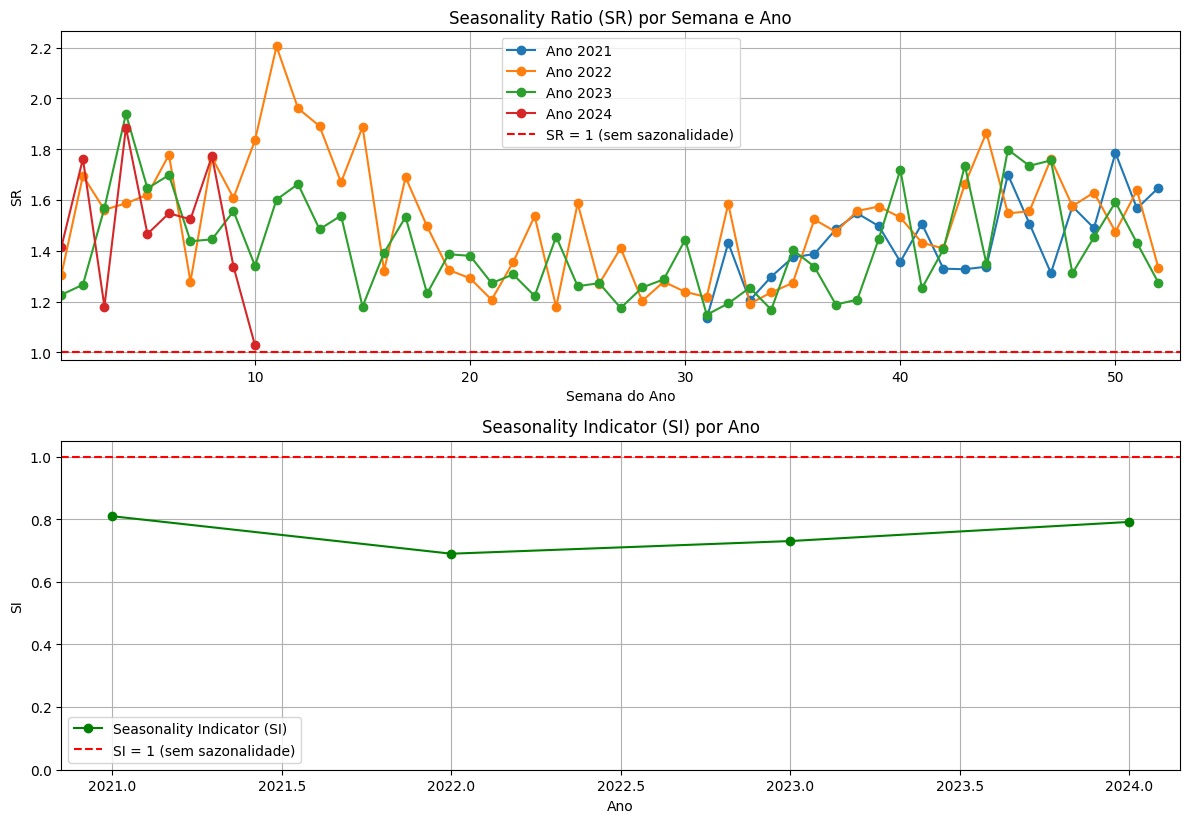

In [21]:
df_SR_12, df_si_12 = calcular_sr_si_resample(df_corrigido_final, coluna='count_12', plotar=True) 

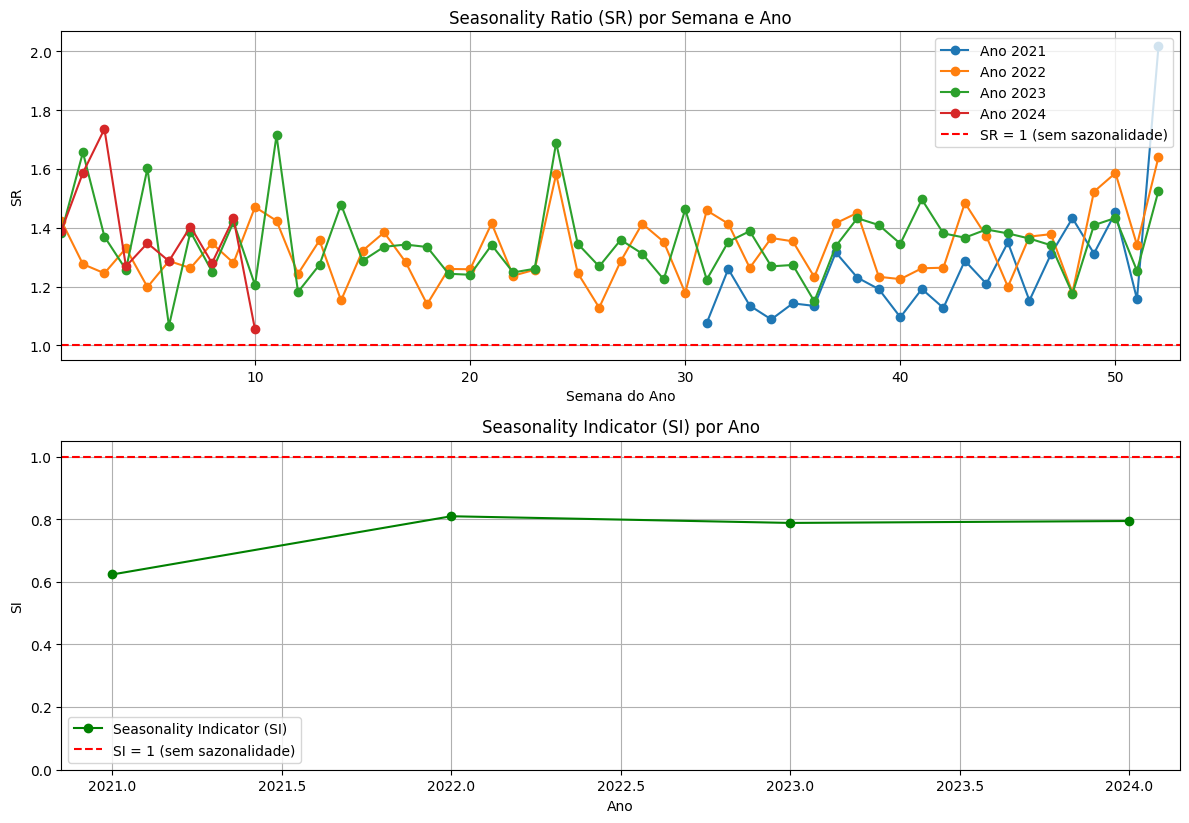

In [24]:
df_SR_8, df_si_8  = calcular_sr_si_resample(df_corrigido_final, coluna='count_8', plotar=True) 

# Novo indice + meteo

In [11]:
df.index = pd.to_datetime(df.index)
df_meteo_semanal = df.resample('W-MON').mean().reset_index()
df_meteo_semanal.columns = ['semana_data', 'temp', 'precip'] 

In [26]:
df_SR_8

,semana_data,mean,max,SR,ano,semana
0,2021-08-02,98.500000,106.0,1.076142,2021,31
1,2021-08-09,91.285714,115.0,1.259781,2021,32
2,2021-08-16,68.714286,78.0,1.135135,2021,33
3,2021-08-23,74.428571,81.0,1.088292,2021,34
4,2021-08-30,84.000000,96.0,1.142857,2021,35
...,...,...,...,...,...,...
131,2024-02-05,137.571429,177.0,1.286604,2024,6
132,2024-02-12,104.672536,147.0,1.404380,2024,7
133,2024-02-19,126.571429,162.0,1.279910,2024,8
134,2024-02-26,118.000000,169.0,1.432203,2024,9


In [25]:
df_SR_12.rename(columns={'datetime': 'semana_data'}, inplace=True)
df_SR_8.rename(columns={'datetime': 'semana_data'}, inplace=True)

In [27]:
df_SR_12_merge = pd.merge(df_SR_12, df_meteo_semanal, on='semana_data', how='left')
df_SR_8_merge = pd.merge(df_SR_8, df_meteo_semanal, on='semana_data', how='left')

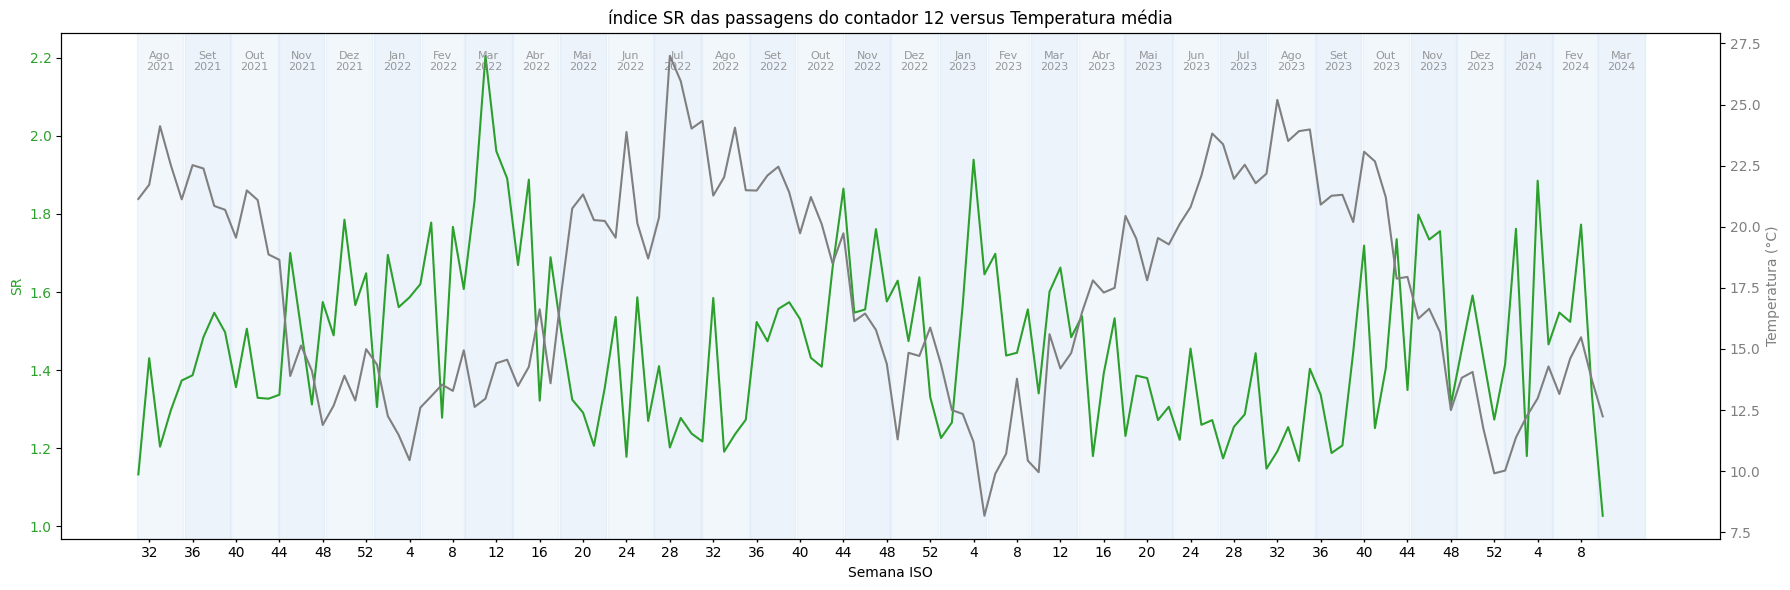

In [29]:
import locale
locale.setlocale(locale.LC_TIME, 'pt_PT.UTF-8')

df_SR_12_merge = df_SR_12_merge.sort_values('semana_data')
df_SR_12_merge = df_SR_12_merge.sort_values('semana_data')
df_SR_12_merge['semana_ano'] = df_SR_12_merge['semana_data'].dt.isocalendar().week

fig, ax1 = plt.subplots(figsize=(18,6))

# Gráfico para índice úteis/não úteis
ax1.plot(df_SR_12_merge['semana_data'], df_SR_12_merge['SR'], color='tab:green', label='SR')
ax1.set_xlabel('Semana ISO')
ax1.set_ylabel('SR', color='tab:green')
ax1.tick_params(axis='y', labelcolor='tab:green')

# Segundo eixo y para temperatura
ax2 = ax1.twinx()
ax2.plot(df_SR_12_merge['semana_data'], df_SR_12_merge['temp'], color='tab:grey', label='Temperatura')
ax2.set_ylabel('Temperatura (°C)', color='tab:grey')
ax2.tick_params(axis='y', labelcolor='tab:grey')

# Título e layout
datas = df_SR_12_merge['semana_data']
min_data = datas.min()
max_data = datas.max()
inicio_sombreado = pd.Timestamp('2021-08-01')
if min_data > inicio_sombreado:
    min_data = inicio_sombreado

inicio_mes = pd.date_range(start=min_data, end=max_data, freq='MS')

for i, start in enumerate(inicio_mes):
    end = start + pd.offsets.MonthEnd(1)
    cor = (0.5, 0.7, 0.9, 0.1 + 0.05 * (i % 2))  # tons azul pastel alternados
    ax1.axvspan(start, end, color=cor)
    #ax1.axvline(start, color='lightgrey', linestyle='--', linewidth=0.5) linhas em cizento entre os meses

        # Nome do mês
    mid = start + (end - start) / 2
    nome_mes = f"{start.strftime('%b').capitalize()}\n{start.year}"
    ax1.text(mid, ax1.get_ylim()[1]*0.98, nome_mes,
                    ha='center', va='top', fontsize=8, color='gray', alpha=0.8)

semanas_para_ticks = df_SR_12_merge[df_SR_12_merge['semana_ano'] % 4 == 0]
ticks_locs = mdates.date2num(semanas_para_ticks['semana_data'])
ticks_labels = [str(w) for w in semanas_para_ticks['semana_ano']]
    
ax1.set_xticks(ticks_locs)
ax1.set_xticklabels(ticks_labels)
ax1.tick_params(axis='x', which='major', length=2, width=1)
plt.title('índice SR das passagens do contador 12 versus Temperatura média')
fig.tight_layout()
plt.show()

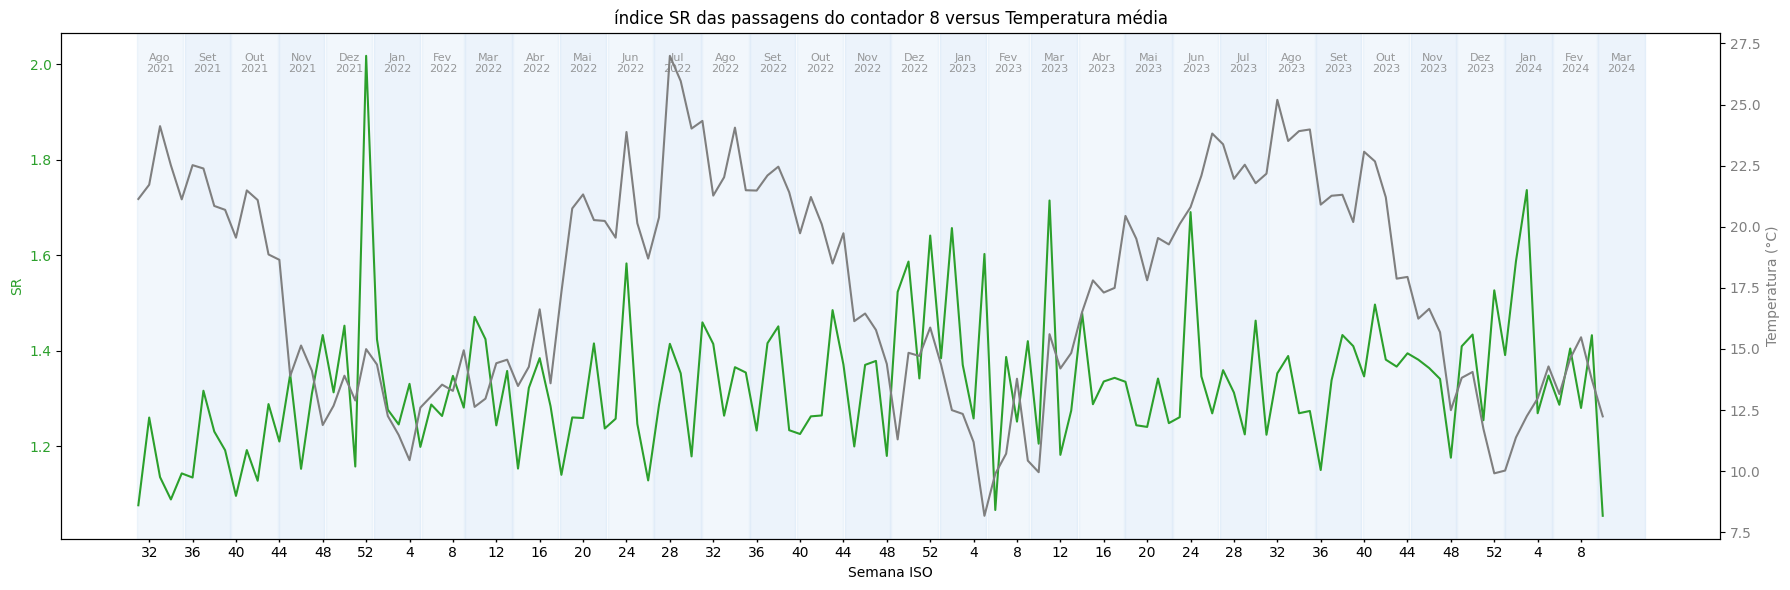

In [31]:
import locale
locale.setlocale(locale.LC_TIME, 'pt_PT.UTF-8')

df_SR_8_merge = df_SR_8_merge.sort_values('semana_data')
df_SR_8_merge = df_SR_8_merge.sort_values('semana_data')
df_SR_8_merge['semana_ano'] = df_SR_8_merge['semana_data'].dt.isocalendar().week

fig, ax1 = plt.subplots(figsize=(18,6))

# Gráfico para índice úteis/não úteis
ax1.plot(df_SR_8_merge['semana_data'], df_SR_8_merge['SR'], color='tab:green', label='SR')
ax1.set_xlabel('Semana ISO')
ax1.set_ylabel('SR', color='tab:green')
ax1.tick_params(axis='y', labelcolor='tab:green')

# Segundo eixo y para temperatura
ax2 = ax1.twinx()
ax2.plot(df_SR_8_merge['semana_data'], df_SR_8_merge['temp'], color='tab:grey', label='Temperatura')
ax2.set_ylabel('Temperatura (°C)', color='tab:grey')
ax2.tick_params(axis='y', labelcolor='tab:grey')

# Título e layout
datas = df_SR_8_merge['semana_data']
min_data = datas.min()
max_data = datas.max()
inicio_sombreado = pd.Timestamp('2021-08-01')
if min_data > inicio_sombreado:
    min_data = inicio_sombreado

inicio_mes = pd.date_range(start=min_data, end=max_data, freq='MS')

for i, start in enumerate(inicio_mes):
    end = start + pd.offsets.MonthEnd(1)
    cor = (0.5, 0.7, 0.9, 0.1 + 0.05 * (i % 2))  # tons azul pastel alternados
    ax1.axvspan(start, end, color=cor)
    #ax1.axvline(start, color='lightgrey', linestyle='--', linewidth=0.5) linhas em cizento entre os meses

        # Nome do mês
    mid = start + (end - start) / 2
    nome_mes = f"{start.strftime('%b').capitalize()}\n{start.year}"
    ax1.text(mid, ax1.get_ylim()[1]*0.98, nome_mes,
                    ha='center', va='top', fontsize=8, color='gray', alpha=0.8)

semanas_para_ticks = df_SR_8_merge[df_SR_8_merge['semana_ano'] % 4 == 0]
ticks_locs = mdates.date2num(semanas_para_ticks['semana_data'])
ticks_labels = [str(w) for w in semanas_para_ticks['semana_ano']]
    
ax1.set_xticks(ticks_locs)
ax1.set_xticklabels(ticks_labels)
ax1.tick_params(axis='x', which='major', length=2, width=1)
plt.title('índice SR das passagens do contador 8 versus Temperatura média')
fig.tight_layout()
plt.show()